<a href="https://colab.research.google.com/github/shlee0619/Project_Disease/blob/main/0204%EC%BD%94%EB%A1%9C%EB%82%98(%EC%B5%9C%EC%A2%85%EB%B3%B8_%EC%B4%88%EC%95%88)2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
########################################
# 0. 환경 설정 & 라이브러리 설치
########################################
# Google Drive 연동
from google.colab import drive
drive.mount('/content/gdrive')

# 필요시 라이브러리 설치
!pip install optuna keras-tuner statsmodels prophet tensorflow==2.12.0 tensorflow-addons==0.23.0 keras-tcn

########################################
# 1. 라이브러리 import
########################################

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (mean_squared_error, mean_absolute_error,
                             r2_score, mean_absolute_percentage_error)
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PowerTransformer
from sklearn.impute import SimpleImputer


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import optuna

# statsmodels (SARIMAX)
import statsmodels.api as sm

# prophet
from prophet import Prophet

# tensorflow / keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import (InputLayer, Dense, Dropout, LSTM,
                                     SimpleRNN, GRU, Conv1D, MaxPooling1D)
# TCN
from tcn import TCN

import gc

In [3]:
########################################
# 2. 데이터 로드 & 기본 전처리
########################################
try:
    # 여러 인코딩 시도
    df_path = '/content/gdrive/MyDrive/hwda02/data/Processed_COVID_Data_Filled.csv'
    try:
        df = pd.read_csv(df_path, encoding='cp949')
    except UnicodeDecodeError:
        try:
            df = pd.read_csv(df_path, encoding='latin-1')
        except UnicodeDecodeError:
            try:
                df = pd.read_csv(df_path, encoding='cp1252')
            except UnicodeDecodeError:
                print("[ERROR] Could not decode file with common encodings.")
                raise
    print("[INFO] CSV file loaded successfully.")
except FileNotFoundError as fe:
    print(f"[ERROR] File not found: {df_path}")
    raise fe
except Exception as e:
    print("[ERROR] Unexpected error occurred while loading CSV.")
    raise e


[INFO] CSV file loaded successfully.


In [4]:
# 날짜 변환
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d', errors='coerce')
df = df.sort_values('Date').dropna(subset=['Date']).reset_index(drop=True)

print("\n=== 데이터 상위 5행 ===")
print(df.head())
print("\n=== 데이터 info ===")
print(df.info())
print("\n=== 데이터 describe ===")
print(df.describe())
df.isna().sum()


=== 데이터 상위 5행 ===
        Date  Cases       SO2        CO        O3       NO2       PM10  \
0 2020-02-01      0  0.003274  0.699089  0.026038  0.022698  63.185218   
1 2020-02-02      0  0.003502  0.748826  0.028493  0.020737  69.092334   
2 2020-02-03      0  0.003140  0.463362  0.029590  0.015894  32.560316   
3 2020-02-04      3  0.003329  0.465114  0.023674  0.019638  29.410079   
4 2020-02-05      3  0.003002  0.374520  0.029291  0.011450  22.960480   

        PM25  평균기온(℃)  평균최고기온(℃)  ...  최저기온(℃)  평균일강수량(mm)  최다일강수량(mm)  \
0  47.416719      2.2        7.8  ...     -6.8         0.0         0.2   
1  52.897434      2.1        7.8  ...    -11.2         0.0         0.7   
2  21.600817      1.3        5.7  ...     -9.7         0.0         0.7   
3  18.842018      0.1        6.3  ...    -18.6         0.3         2.0   
4  11.594881     -3.6        1.0  ...    -18.9         0.0        26.0   

   평균풍속(m/s)  최대풍속(m/s)  최대순간풍속(m/s)  평균습도(%rh)  최저습도(%rh)  일조합(hr)  \
0        1.5       1

,0
Date,0
Cases,0
SO2,0
CO,0
O3,0
NO2,0
PM10,0
PM25,0
평균기온(℃),0
평균최고기온(℃),0


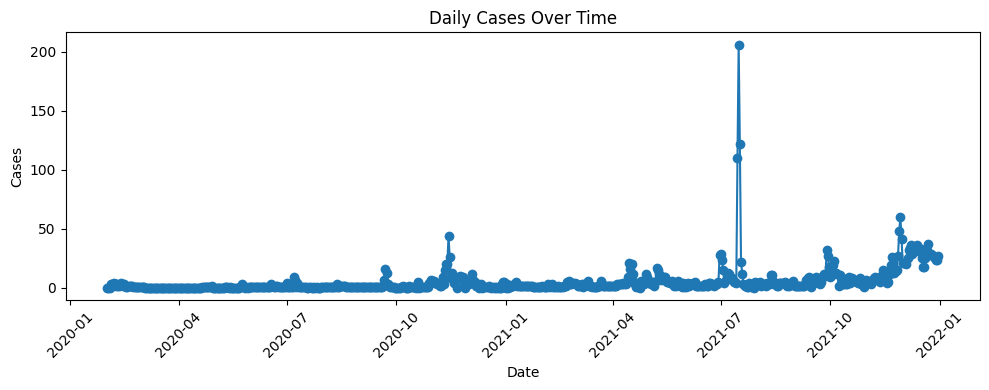

In [5]:
# EDA 시각화(기본)
plt.figure(figsize=(10,4))
plt.plot(df['Date'], df['Cases'], marker='o')
plt.title("Daily Cases Over Time")
plt.xlabel("Date")
plt.ylabel("Cases")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [6]:
########################################
########################################

# (2) 몇 개의 lag/rolling/차분
df['Cases_lag1'] = df['Cases'].shift(1)
df['Cases_lag7'] = df['Cases'].shift(7)
for ws in [7,14]:
    df[f'Cases_ma{ws}'] = df['Cases'].rolling(ws).mean()
    df[f'Cases_std{ws}'] = df['Cases'].rolling(ws).std()
df['Cases_log'] = np.log1p(df['Cases'])
df['Cases_diff'] = df['Cases'].diff(1)

In [7]:
df['Cases_lag1_log'] = np.log1p(df['Cases_lag1'])  # 1일 전 환자수 로그변환
df['Cases_lag7_log'] = np.log1p(df['Cases_lag7'])  # 7일 전 환자수 로그변환

In [8]:
df['Cases_lag1_diff'] = df['Cases_lag1'].diff(1)
df['Cases_lag1_diff']

,Cases_lag1_diff
0,NaN
1,NaN
2,0.0
3,0.0
4,3.0
...,...
695,-1.0
696,-2.0
697,-1.0
698,-1.0


In [9]:
df[f'Cases_ma7']   # 최근 7일(과거) 평균 환자수 → O
df[f'Cases_std14'] # 최근 14일(과거) 표준편차 → O

,Cases_std14
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
695,5.341626
696,5.316882
697,5.225151
698,4.968030


In [10]:
df['Cases_diff2'] = df['Cases_diff'].diff(1)

In [11]:
# 결측치 제거(shift/rolling 후 생긴)
df.isna().sum()

,0
Date,0
Cases,0
SO2,0
CO,0
O3,0
NO2,0
PM10,0
PM25,0
평균기온(℃),0
평균최고기온(℃),0


In [12]:
df.dropna(inplace=True)

/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 44512 (\N{HANGUL SYLLABLE GYUN}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 50728 (\N{HANGUL SYLLABLE ON}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 52572 (\N{HANGUL SYLLABLE COE}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/us

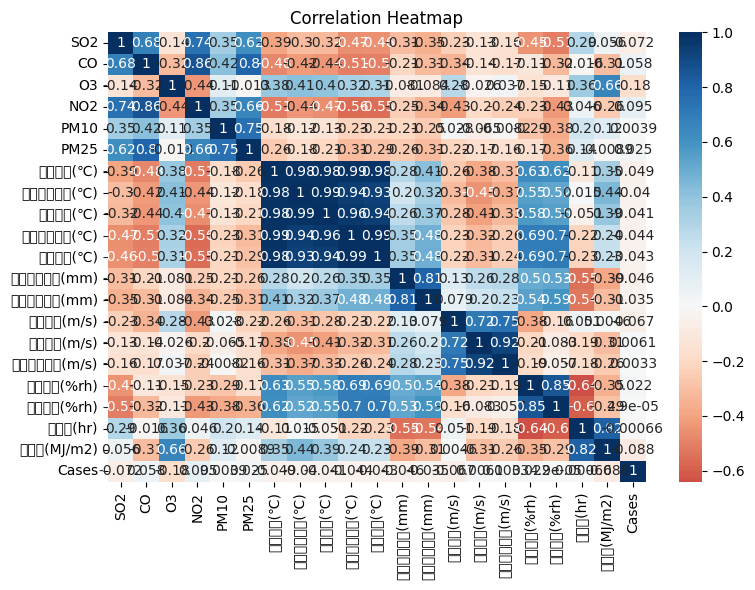

In [13]:
# EDA(상관관계 히트맵)
cols_for_corr = [    "SO2", "CO", "O3", "NO2", "PM10", "PM25",
    "평균기온(℃)", "평균최고기온(℃)", "최고기온(℃)", "평균최저기온(℃)", "최저기온(℃)",
    "평균일강수량(mm)", "최다일강수량(mm)", "평균풍속(m/s)", "최대풍속(m/s)", "최대순간풍속(m/s)",
    "평균습도(%rh)", "최저습도(%rh)", "일조합(hr)", "일사합(MJ/m2)","Cases"]
plt.figure(figsize=(8,6))
sns.heatmap(df[cols_for_corr].corr(), annot=True, cmap='RdBu', center=0)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

In [14]:
########################################
# 4. Train/Val/Test 분할 (날짜 기준)
########################################
train_end_date = pd.to_datetime('2021-05-01')
val_end_date   = pd.to_datetime('2021-07-31')

train_df = df[df['Date'] < train_end_date]
val_df   = df[(df['Date']>=train_end_date)&(df['Date']<val_end_date)]
test_df  = df[df['Date'] >= val_end_date]

print(f"Train={train_df.shape}, Val={val_df.shape}, Test={test_df.shape}")

Train=(442, 34), Val=(91, 34), Test=(154, 34)


In [15]:
rf_features = ["SO2", "CO", "O3", "NO2", "PM10", "PM25",
    "평균기온(℃)", "평균최고기온(℃)", "최고기온(℃)", "평균최저기온(℃)", "최저기온(℃)",
    "평균일강수량(mm)", "최다일강수량(mm)", "평균풍속(m/s)", "최대풍속(m/s)", "최대순간풍속(m/s)",
    "평균습도(%rh)", "최저습도(%rh)", "일조합(hr)", "일사합(MJ/m2)",'Cases_lag1', 'Cases_lag7',
 'Cases_ma7', 'Cases_ma14',
 'Cases_std7', 'Cases_std14',
 'Cases_lag1_log', 'Cases_lag7_log',  # 로그 변환된 과거 값
 'Cases_lag1_diff', 'Cases_diff2']

In [16]:
features = ["SO2", "CO", "O3", "NO2", "PM10", "PM25",
    "평균기온(℃)", "평균최고기온(℃)", "최고기온(℃)", "평균최저기온(℃)", "최저기온(℃)",
    "평균일강수량(mm)", "최다일강수량(mm)", "평균풍속(m/s)", "최대풍속(m/s)", "최대순간풍속(m/s)",
    "평균습도(%rh)", "최저습도(%rh)", "일조합(hr)", "일사합(MJ/m2)",'Cases_lag1', 'Cases_lag7',
 'Cases_ma7', 'Cases_ma14',
 'Cases_std7', 'Cases_std14',
 'Cases_lag1_log', 'Cases_lag7_log',
 'Cases_lag1_diff', 'Cases_diff2']

In [19]:
########################################
# 5. 랜덤 포레스트 (회귀)
########################################

X_train_rf = train_df[rf_features]
y_train_rf = train_df['Cases']
X_val_rf   = val_df[rf_features]
y_val_rf   = val_df['Cases']
X_test_rf  = test_df[rf_features]
y_test_rf  = test_df['Cases']

# TimeSeriesSplit + GridSearchCV
rf_params = {
    'n_estimators':[50,100],
    'max_depth':[3,5,7],
    'min_samples_leaf':[1,3,5]
}
tscv = TimeSeriesSplit(n_splits=3)
print("\n[RandomForest] GridSearch...")
rf_grid = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=rf_params,
    scoring='neg_mean_absolute_error',
    cv=tscv,
    n_jobs=-1,
    verbose=1
)
rf_grid.fit(X_train_rf, y_train_rf)

best_rf = rf_grid.best_estimator_


# Feature Importance 확인 및 시각화 (추가 코드)
feature_importances = pd.Series(best_rf.feature_importances_, index=rf_features).sort_values(ascending=False)

print("\n[RandomForest] Feature Importances:")
print(feature_importances)
# Validation
val_pred_rf = best_rf.predict(X_val_rf)
val_mae_rf = mean_absolute_error(y_val_rf, val_pred_rf)
print("[RF] val MAE=", val_mae_rf)

# Test
y_pred_rf = best_rf.predict(X_test_rf)
rf_mae = mean_absolute_error(y_test_rf, y_pred_rf)
rf_rmse = np.sqrt(mean_squared_error(y_test_rf, y_pred_rf))
rf_r2 = r2_score(y_test_rf, y_pred_rf)
print("[RF on Test] MAE=%.3f, RMSE=%.3f, R2=%.3f" % (rf_mae, rf_rmse, rf_r2))


[RandomForest] GridSearch...
Fitting 3 folds for each of 18 candidates, totalling 54 fits

[RandomForest] Feature Importances:
Cases_lag1         0.249420
Cases_lag1_log     0.214451
Cases_diff2        0.127554
Cases_std7         0.120645
Cases_ma7          0.069738
Cases_lag1_diff    0.047723
Cases_ma14         0.020079
최저기온(℃)            0.017204
최대풍속(m/s)          0.013143
최대순간풍속(m/s)        0.011162
평균풍속(m/s)          0.010924
PM10               0.010340
Cases_lag7_log     0.008120
PM25               0.007259
최저습도(%rh)          0.006990
최다일강수량(mm)         0.006865
Cases_std14        0.006487
일사합(MJ/m2)         0.006345
일조합(hr)            0.006244
CO                 0.005712
평균최고기온(℃)          0.005614
평균습도(%rh)          0.004404
평균기온(℃)            0.004386
최고기온(℃)            0.003791
NO2                0.003262
SO2                0.002994
평균최저기온(℃)          0.002926
Cases_lag7         0.002920
O3                 0.002662
평균일강수량(mm)         0.000636
dtype: float64
[RF] val MAE= 6.1

In [ ]:
# from sklearn.model_selection import learning_curve
# train_sizes_rf, train_scores_rf, val_scores_rf = learning_curve(
#     rf_grid, X_train_rf, y_train_rf,
#     cv=tscv, scoring='neg_mean_absolute_error', n_jobs=-1,
#     train_sizes=np.linspace(0.1, 1.0, 10)
# )
# train_scores_rf_mean = -np.mean(train_scores_rf, axis=1)
# val_scores_rf_mean = -np.mean(val_scores_rf, axis=1)

# plt.figure(figsize=(8,6))
# plt.plot(train_sizes_rf, train_scores_rf_mean, 'o-', label='Training MAE')
# plt.plot(train_sizes_rf, val_scores_rf_mean, 'o-', label='Validation MAE')
# plt.title('RandomForest Learning Curve')
# plt.xlabel('Training Sample Size')
# plt.ylabel('MAE')
# plt.legend()
# plt.show()

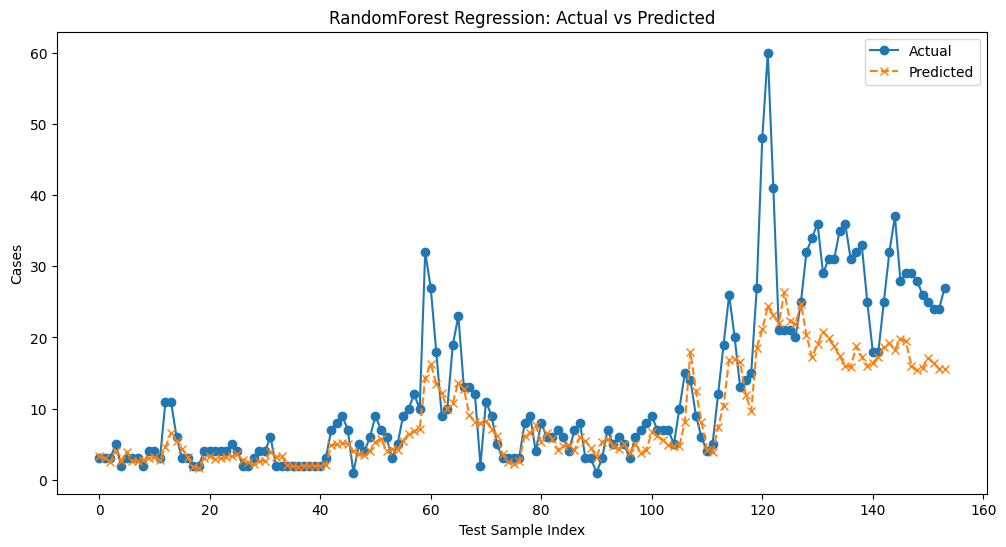

In [ ]:
########################################
# RandomForest 시각화 (Loss 추이 & 예측 결과)
########################################
# 테스트셋 예측 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test_rf)), y_test_rf, label='Actual', marker='o', linestyle='-')
plt.plot(range(len(y_test_rf)), y_pred_rf, label='Predicted', marker='x', linestyle='--')
plt.xlabel("Test Sample Index")
plt.ylabel("Cases")
plt.title("RandomForest Regression: Actual vs Predicted")
plt.legend()
plt.show()


In [ ]:
########################################
# 6. SARIMAX (ARIMAX)
########################################
sarimax_exog = ["SO2", "CO", "O3", "NO2", "PM10", "PM25",
    "평균기온(℃)", "평균최고기온(℃)", "최고기온(℃)", "평균최저기온(℃)", "최저기온(℃)",
    "평균일강수량(mm)", "최다일강수량(mm)", "평균풍속(m/s)", "최대풍속(m/s)", "최대순간풍속(m/s)",
    "평균습도(%rh)", "최저습도(%rh)", "일조합(hr)", "일사합(MJ/m2)", 'Cases_ma7', 'Cases_ma14',
 'Cases_std7', 'Cases_std14',
 'Cases_lag1_log', 'Cases_lag7_log',  # 로그 변환된 과거 값
 'Cases_lag1_diff', 'Cases_diff2', 'Cases_ma7', 'Cases_ma14',
 'Cases_std7', 'Cases_std14',
 'Cases_lag1_log', 'Cases_lag7_log',  # 로그 변환된 과거 값
 'Cases_lag1_diff', 'Cases_diff2'
]
y_train_sar = train_df['Cases']
y_test_sar  = test_df['Cases']
X_train_sar = train_df[sarimax_exog]
X_test_sar  = test_df[sarimax_exog]



In [ ]:
y_train_sar.isna().sum()

0

In [ ]:
X_train_sar.isna().sum()

,0
SO2,0
CO,0
O3,0
NO2,0
PM10,0
PM25,0
평균기온(℃),0
평균최고기온(℃),0
최고기온(℃),0
평균최저기온(℃),0


In [ ]:
# X_train_sar = X_train_sar.fillna(0)

In [ ]:
sar_model = sm.tsa.statespace.SARIMAX(
    endog=y_train_sar,
    exog=X_train_sar,
    order=(1,0,1),
    seasonal_order=(0,0,0,0),
    enforce_stationarity=False,
    enforce_invertibility=False
)
sar_result = sar_model.fit(disp=False)
print(sar_result.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Cases   No. Observations:                  442
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -589.355
Date:                Tue, 04 Feb 2025   AIC                           1256.710
Time:                        03:34:27   BIC                           1416.094
Sample:                             0   HQIC                          1319.587
                                - 442                                         
Covariance Type:                  opg                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
SO2             -1010.0312    310.725     -3.251      0.001   -1619.041    -401.022
CO                 -1.5434      3.025     -0.510      0.610      -7.473       4.386
O3                  5.4930     1

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
n_test = len(y_test_sar)
pred_sar = sar_result.predict(
    start=len(y_train_sar),
    end=len(y_train_sar)+n_test-1,
    exog=X_test_sar
)
sar_mae = mean_absolute_error(y_test_sar, pred_sar)
sar_rmse= np.sqrt(mean_squared_error(y_test_sar, pred_sar))
print("[SARIMAX] MAE=%.3f, RMSE=%.3f" % (sar_mae, sar_rmse))


[SARIMAX] MAE=4.553, RMSE=7.609


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


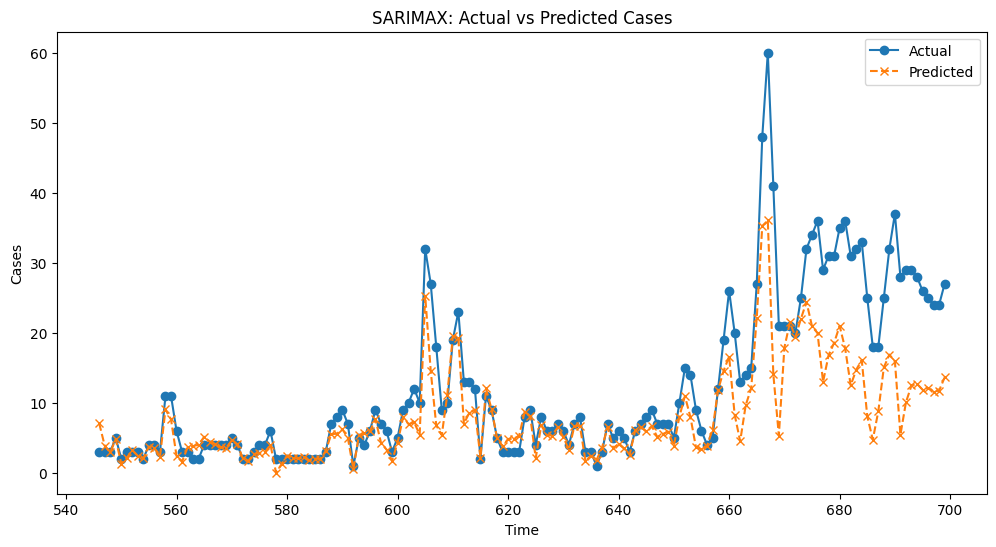

In [ ]:
########################################
# SARIMAX 예측 결과 시각화 및 잔차 분석
########################################
import matplotlib.pyplot as plt

# 실제값과 예측값 시각화 (x축은 인덱스 또는 날짜 사용)
plt.figure(figsize=(12,6))
# 만약 y_test_sar의 인덱스가 날짜라면 그대로 사용 가능
plt.plot(y_test_sar.index, y_test_sar, label='Actual', marker='o', linestyle='-')
plt.plot(y_test_sar.index, pred_sar, label='Predicted', marker='x', linestyle='--')
plt.xlabel("Time")
plt.ylabel("Cases")
plt.title("SARIMAX: Actual vs Predicted Cases")
plt.legend()
plt.show()

In [ ]:
features = ["SO2", "CO", "O3", "NO2", "PM10", "PM25",
    "평균기온(℃)", "평균최고기온(℃)", "최고기온(℃)", "평균최저기온(℃)", "최저기온(℃)",
    "평균일강수량(mm)", "최다일강수량(mm)", "평균풍속(m/s)", "최대풍속(m/s)", "최대순간풍속(m/s)",
    "평균습도(%rh)", "최저습도(%rh)", "일조합(hr)", "일사합(MJ/m2)",'Cases_lag1', 'Cases_lag7',
 'Cases_ma7', 'Cases_ma14',
 'Cases_std7', 'Cases_std14',
 'Cases_lag1_log', 'Cases_lag7_log']

In [ ]:
########################################
# 7. LSTM 예시 (시퀀스 생성)
########################################
lstm_feats = features
X_lstm_arr = df[lstm_feats].values
y_lstm_arr = df['Cases'].values
# 예시: X_lstm_arr 배열에서 nan 값이 있는 위치를 찾기
nan_indices = np.where(np.isnan(X_lstm_arr))
print("nan 값이 있는 인덱스 (행, 열):", nan_indices)

# 열 인덱스만 확인하려면
nan_column_indices = np.unique(nan_indices[1])
print("nan 값이 포함된 열 인덱스:", nan_column_indices)

# 만약 lstm_feats 리스트에 각 열의 이름이 있다면,
# 어떤 열에 nan 값이 있는지 이름으로 확인할 수 있습니다.
for col_idx in nan_column_indices:
    print(f"열 인덱스 {col_idx} : {lstm_feats[col_idx]}")
np.isnan(X_lstm_arr)

nan 값이 있는 인덱스 (행, 열): (array([], dtype=int64), array([], dtype=int64))
nan 값이 포함된 열 인덱스: []


array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [ ]:


# MinMax
scaler_x_lstm = MinMaxScaler()
X_lstm_scaled = scaler_x_lstm.fit_transform(X_lstm_arr)
scaler_y_lstm = MinMaxScaler()
y_lstm_scaled = scaler_y_lstm.fit_transform(y_lstm_arr.reshape(-1,1)).flatten()

window_size = 7
X_lstm_seq, y_lstm_seq = [], []
for i in range(len(X_lstm_scaled) - window_size):
    X_lstm_seq.append(X_lstm_scaled[i:i+window_size])
    y_lstm_seq.append(y_lstm_scaled[i+window_size])
X_lstm_seq = np.array(X_lstm_seq)
y_lstm_seq = np.array(y_lstm_seq)

cut_date_lstm = pd.to_datetime('2021-07-01')
cut_idx_lstm  = df.index[df['Date'] >= cut_date_lstm][0]
split_idx_lstm = max(0, cut_idx_lstm - window_size)

X_train_lstm = X_lstm_seq[:split_idx_lstm]
y_train_lstm = y_lstm_seq[:split_idx_lstm]
X_test_lstm  = X_lstm_seq[split_idx_lstm:]
y_test_lstm_ = y_lstm_seq[split_idx_lstm:]

# LSTM 모델
lstm_model_ = keras.Sequential([
    LSTM(32, activation='tanh', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    Dropout(0.2),
    Dense(1)
])
lstm_model_.compile(optimizer='adam', loss='mse')
lstm_model_.summary()

hist_lstm = lstm_model_.fit(
    X_train_lstm, y_train_lstm,
    validation_split=0.2,
    epochs=30, batch_size=16, shuffle=False, verbose=1
)

# 예측
lstm_pred_scaled = lstm_model_.predict(X_test_lstm).flatten()
lstm_pred = scaler_y_lstm.inverse_transform(lstm_pred_scaled.reshape(-1,1)).flatten()
y_test_lstm_ = scaler_y_lstm.inverse_transform(y_test_lstm_.reshape(-1,1)).flatten()

lstm_mae = mean_absolute_error(y_test_lstm_, lstm_pred)
lstm_rmse= np.sqrt(mean_squared_error(y_test_lstm_, lstm_pred))
print("[LSTM] MAE=%.3f, RMSE=%.3f" % (lstm_mae, lstm_rmse))

Model: "sequential_95"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_21 (LSTM)              (None, 32)                7808      
                                                                 
 dropout_27 (Dropout)        (None, 32)                0         
                                                                 
 dense_94 (Dense)            (None, 1)                 33        
                                                                 
Total params: 7,841
Trainable params: 7,841
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
26/26 [==============================] - 24s 18ms/step - loss: 0.0121 - val_loss: 0.0017
Epoch 2/30
26/26 [==============================] - 0s 8ms/step - loss: 0.0045 - val_loss: 0.0078
Epoch 3/30
26/26 [==============================] - 0s 9ms/step - loss: 0.0024 - val_loss: 0.0016
Epoch 4/30
26/26 [=

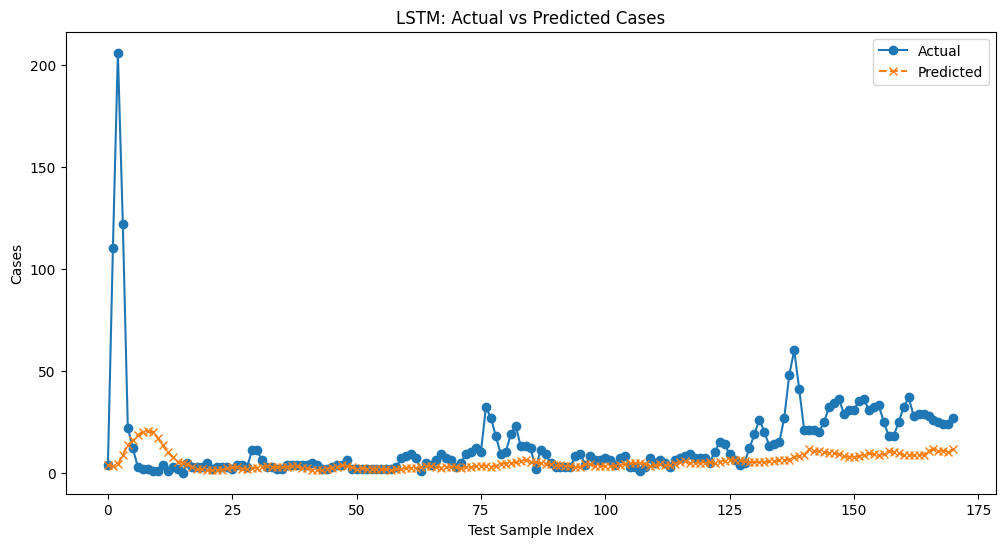

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(range(len(y_test_lstm_)), y_test_lstm_, label='Actual', marker='o', linestyle='-')
plt.plot(range(len(lstm_pred)), lstm_pred, label='Predicted', marker='x', linestyle='--')
plt.xlabel("Test Sample Index")
plt.ylabel("Cases")
plt.title("LSTM: Actual vs Predicted Cases")
plt.legend()
plt.show()

In [ ]:
########################################
# 8. GRU 예시
########################################
# 기존 X_lstm_seq, y_lstm_seq 재사용
gru_model_ = keras.Sequential([
    GRU(32, activation='tanh', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    Dropout(0.2),
    Dense(1)
])
gru_model_.compile(optimizer='adam', loss='mse')
gru_model_.summary()

hist_gru = gru_model_.fit(
    X_train_lstm, y_train_lstm,
    validation_split=0.2,
    epochs=30, batch_size=16, shuffle=False, verbose=1
)

gru_pred_scaled = gru_model_.predict(X_test_lstm).flatten()
gru_pred = scaler_y_lstm.inverse_transform(gru_pred_scaled.reshape(-1,1)).flatten()
y_test_gru_ = y_test_lstm_

gru_mae = mean_absolute_error(y_test_gru_, gru_pred)
gru_rmse= np.sqrt(mean_squared_error(y_test_gru_, gru_pred))
print("[GRU] MAE=%.3f, RMSE=%.3f" % (gru_mae, gru_rmse))

Model: "sequential_90"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_5 (GRU)                 (None, 32)                5952      
                                                                 
 dropout_25 (Dropout)        (None, 32)                0         
                                                                 
 dense_89 (Dense)            (None, 1)                 33        
                                                                 
Total params: 5,985
Trainable params: 5,985
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
26/26 [==============================] - 5s 32ms/step - loss: 0.0312 - val_loss: 0.0226
Epoch 2/30
26/26 [==============================] - 0s 9ms/step - loss: 0.0192 - val_loss: 0.0071
Epoch 3/30
26/26 [==============================] - 0s 8ms/step - loss: 0.0130 - val_loss: 0.0030
Epoch 4/30
26/26 [==

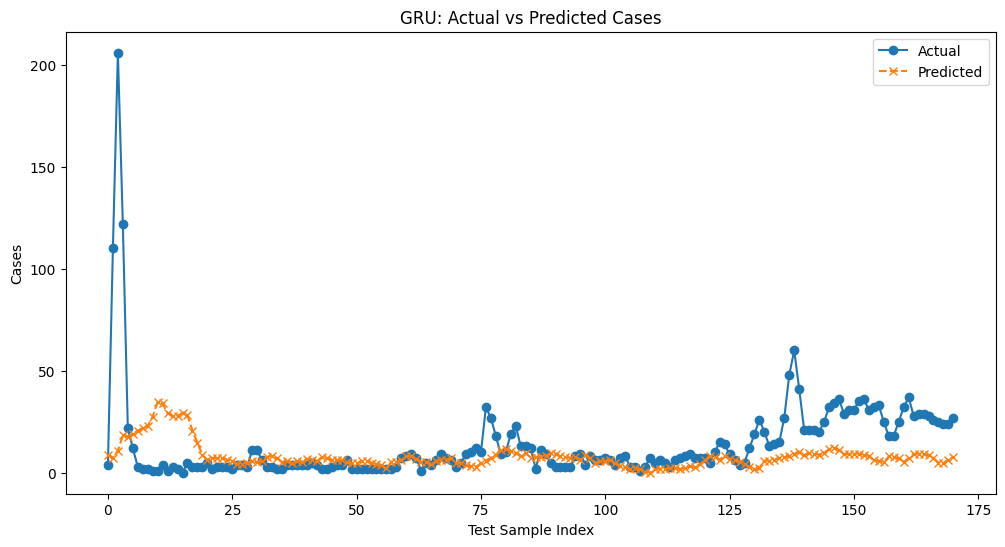

In [ ]:
########################################
# GRU 예측 결과 시각화 및 잔차 분석
########################################
import matplotlib.pyplot as plt

# 예측 결과 (Actual vs Predicted) 시각화
plt.figure(figsize=(12,6))
plt.plot(range(len(y_test_gru_)), y_test_gru_, label='Actual', marker='o', linestyle='-')
plt.plot(range(len(gru_pred)), gru_pred, label='Predicted', marker='x', linestyle='--')
plt.xlabel("Test Sample Index")
plt.ylabel("Cases")
plt.title("GRU: Actual vs Predicted Cases")
plt.legend()
plt.show()

DEBUG:cmdstanpy:input tempfile: /tmp/tmps_ifzw99/c_5dcsl1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmps_ifzw99/p02wrcym.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18307', 'data', 'file=/tmp/tmps_ifzw99/c_5dcsl1.json', 'init=/tmp/tmps_ifzw99/p02wrcym.json', 'output', 'file=/tmp/tmps_ifzw99/prophet_model5c2tnrzi/prophet_model-20250204075400.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:54:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:54:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2020-10-03 00:00:00 and 2021-05-31 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ba8fab5db10>



[Prophet] MAE=0.154, RMSE=0.182, R2=1.000


DEBUG:cmdstanpy:input tempfile: /tmp/tmps_ifzw99/lmdrj9i1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmps_ifzw99/_y5o0m6q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmps_ifzw99/k80vdx5g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:input tempfile: /tmp/tmps_ifzw99/t94rnith.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21135', 'data', 'file=/tmp/tmps_ifzw99/lmdrj9i1.json', 'init=/tmp/tmps_ifzw99/k80vdx5g.json', 'output', 'file=/tmp/tmps_ifzw99/prophet_model88db23wc/prophet_model-20250204075403.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86025', 'data', 'file=/tmp/tmps_ifzw99/_y5o0m6q.json', 'init=/tmp/tmps_ifzw99/t94rnith.json', 'output', 'file=/t


[Prophet CV] 평균 성능:
mae      0.056589
rmse     0.103451
mdape    0.003375
dtype: float64


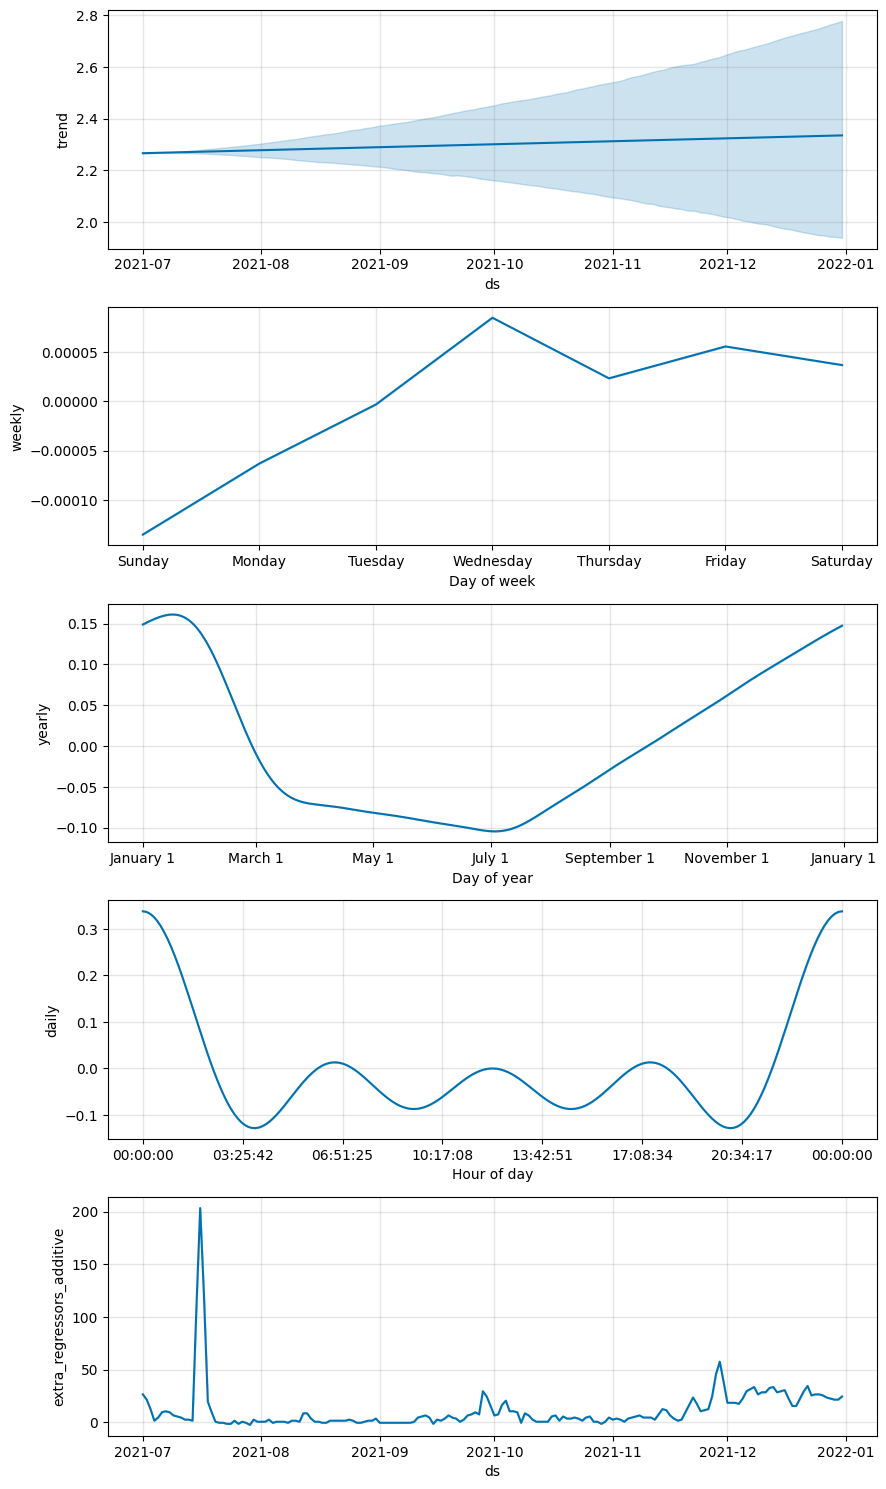

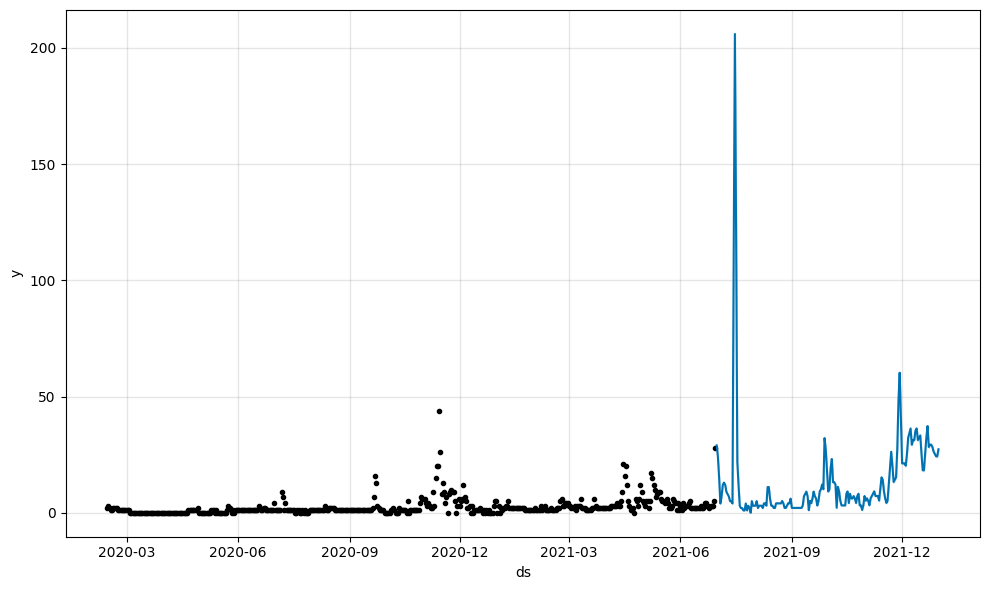

In [27]:
########################################
# 8. Prophet (Meta의 시계열 예측 모델)
########################################

# 필수 라이브러리 설치 (Colab 등 환경에서)
# !pip install prophet
features = ["SO2", "CO", "O3", "NO2", "PM10", "PM25",
    "평균기온(℃)", "평균최고기온(℃)", "최고기온(℃)", "평균최저기온(℃)", "최저기온(℃)",
    "평균일강수량(mm)", "최다일강수량(mm)", "평균풍속(m/s)", "최대풍속(m/s)", "최대순간풍속(m/s)",
    "평균습도(%rh)", "최저습도(%rh)", "일조합(hr)", "일사합(MJ/m2)",'Cases_lag1', 'Cases_lag7',
 'Cases_ma7', 'Cases_ma14',
 'Cases_std7', 'Cases_std14',
 'Cases_lag1_log', 'Cases_lag7_log',
 'Cases_lag1_diff', 'Cases_diff2']


from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics

# 1. 데이터 준비
# Prophet은 'ds'(날짜), 'y'(타겟) 컬럼 필수 + 추가 regressor 컬럼
prophet_df = df[['Date', 'Cases'] + features].copy()  # SARIMAX와 동일 외생변수 사용
prophet_df.columns = ['ds', 'y'] + features  # 컬럼명 변경

# 날짜 기준 train/test 분할 (기존 분할과 일관성 유지)

cut_date_lstm = pd.to_datetime('2021-07-01')
train_prophet = prophet_df[prophet_df['ds'] < cut_date_lstm]
test_prophet = prophet_df[prophet_df['ds'] >= cut_date_lstm]

# 2. 모델 정의 (Hyperparameter 튜닝 예시)
model_prophet = Prophet(
    growth='linear',  # 'linear' 또는 'logistic'
    yearly_seasonality=True,  # 연간 계절성 (데이터 기간이 1년 미만이면 False)
    weekly_seasonality=True,   # 주간 계절성
    daily_seasonality=True,   # 일간 계절성 (일별 데이터 아닌 경우)
    changepoint_prior_scale=0.05,  # 트렌드 변화 민감도 (높을수록 많은 변화점)
    seasonality_mode='additive'   # 'additive' 또는 'multiplicative'
)

# 3. 외생변수(Regressor) 추가
for col in features:
    model_prophet.add_regressor(col)  # 모든 외생변수 등록

# 4. 모델 학습
model_prophet.fit(train_prophet)

# 5. 예측용 Future DataFrame 생성
future = model_prophet.make_future_dataframe(
    periods=len(test_prophet),  # 예측할 기간(테스트셋 길이)
    include_history=False       # 히스토리 포함 여부
)

# 외생변수 추가 (테스트 데이터에서 가져옴)
future[features] = test_prophet[features].values

# 6. 예측 수행
forecast = model_prophet.predict(future)

# 7. 성능 평가
prophet_pred = forecast['yhat'].values
prophet_mae = mean_absolute_error(test_prophet['y'], prophet_pred)
prophet_rmse = np.sqrt(mean_squared_error(test_prophet['y'], prophet_pred))
prophet_r2 = r2_score(test_prophet['y'], prophet_pred)

print("\n[Prophet] MAE=%.3f, RMSE=%.3f, R2=%.3f" %
      (prophet_mae, prophet_rmse, prophet_r2))

# 8. (선택) 교차검증 (시계열 특화)
# 초기 학습 기간 180일, 예측 기간 30일, 평가 간격 60일
df_cv = cross_validation(
    model_prophet,
    initial='180 days',
    period='60 days',
    horizon='30 days',
    parallel="processes"
)

# 교차검증 결과 평균 성능
cv_perf = performance_metrics(df_cv)
print("\n[Prophet CV] 평균 성능:")
print(cv_perf[['mae', 'rmse', 'mdape']].mean())

# 9. 시각화 (트렌드+계절성 분석)
fig1 = model_prophet.plot_components(forecast)
fig2 = model_prophet.plot(forecast)
plt.show()

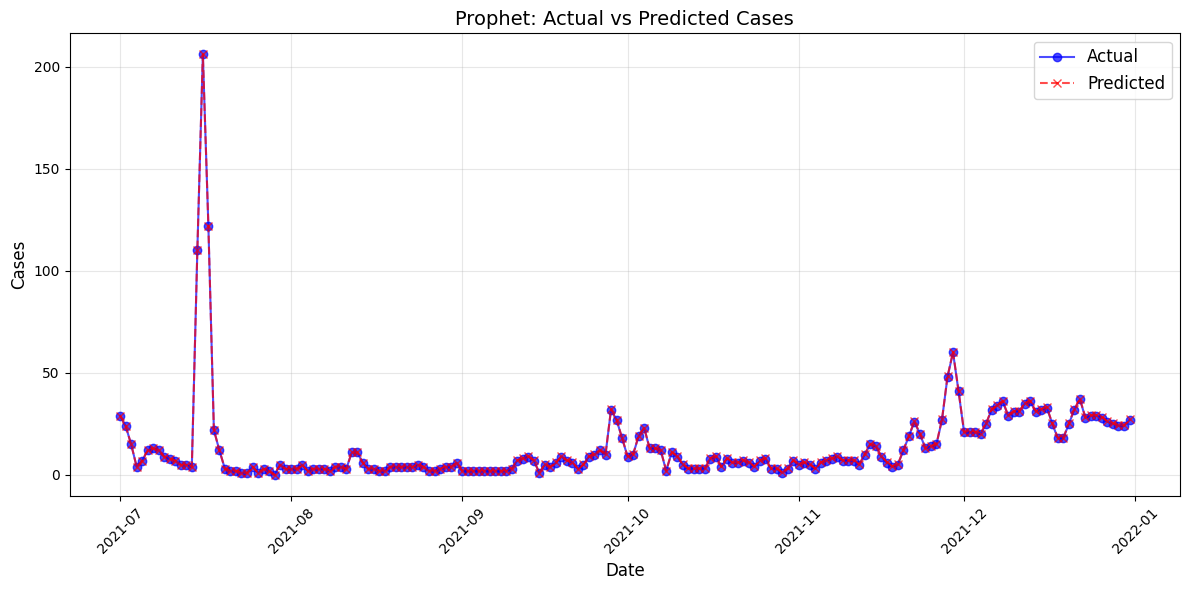

In [28]:
# 1. 시각화 데이터 준비
test_dates = test_prophet['ds']  # 테스트 기간의 날짜
y_true = test_prophet['y']       # 실제값
y_pred = forecast['yhat']        # 예측값

# 2. 시각화
plt.figure(figsize=(12, 6))

# 실제값 플롯
plt.plot(test_dates, y_true,
         label='Actual',
         marker='o',
         linestyle='-',
         color='blue',
         alpha=0.7)

# 예측값 플롯
plt.plot(test_dates, y_pred,
         label='Predicted',
         marker='x',
         linestyle='--',
         color='red',
         alpha=0.7)

# 그래프 설정
plt.xlabel("Date", fontsize=12)
plt.ylabel("Cases", fontsize=12)
plt.title("Prophet: Actual vs Predicted Cases", fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.xticks(rotation=45)  # 날짜 라벨 회전
plt.tight_layout()  # 레이아웃 조정
plt.show()

In [ ]:
########################################
# 9. 앙상블 (단순 가중/Stacking 등)
########################################
# 예시: RandomForest, SARIMAX, LSTM, GRU 결과
# 실제로는 시점 맞춰서, min_len 등 처리 필요
from xgboost import XGBRegressor
min_len_ = min(len(y_test_rf), len(pred_sar), len(lstm_pred), len(gru_pred))
stack_X = np.column_stack([
    y_pred_rf[-min_len_:],
    pred_sar[-min_len_:],
    lstm_pred[-min_len_:],
    gru_pred[-min_len_:]
])
stack_y = y_test_rf.values[-min_len_:]  # RF기준, 필요시 조정

stack_imputer = SimpleImputer(strategy='mean')
stack_X_ = stack_imputer.fit_transform(stack_X)

stack_final = XGBRegressor()
stack_final.fit(stack_X_, stack_y)
stack_pred = stack_final.predict(stack_X_)

stack_mae = mean_absolute_error(stack_y, stack_pred)
stack_rmse= np.sqrt(mean_squared_error(stack_y, stack_pred))
print("[Stacking Ensemble] MAE=%.3f, RMSE=%.3f" % (stack_mae, stack_rmse))

[Stacking Ensemble] MAE=0.001, RMSE=0.001


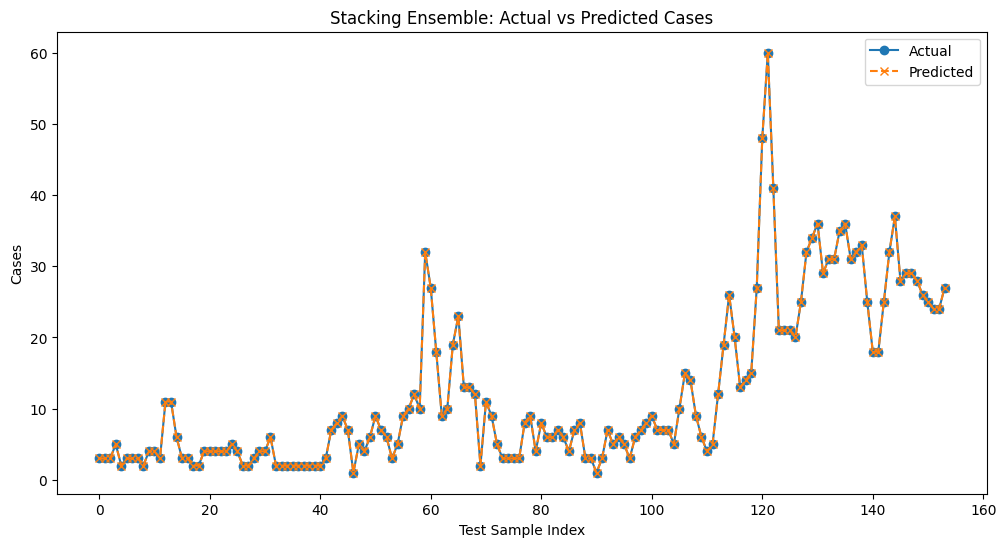

In [ ]:
# 예측 결과 시각화: 실제값과 앙상블 예측값 비교
plt.figure(figsize=(12,6))
plt.plot(range(len(stack_y)), stack_y, label='Actual', marker='o', linestyle='-')
plt.plot(range(len(stack_pred)), stack_pred, label='Predicted', marker='x', linestyle='--')
plt.xlabel("Test Sample Index")
plt.ylabel("Cases")
plt.title("Stacking Ensemble: Actual vs Predicted Cases")
plt.legend()
plt.show()

In [ ]:
########################################
# 10. 기타 (TCN, Optuna)
########################################
# 예시: TCN 하이퍼파라미터 최적화 (간단)
# (이미 user code 참고)

# 시퀀스 데이터 생성 (window_size=14)
lstm_features = features
X_arr = df[lstm_features].values
y_arr = df['Cases'].values

# 스케일링 (차분 데이터용 새 스케일러 생성)
scaler_X_diff = StandardScaler()
X_scaled_diff = scaler_X_diff.fit_transform(X_arr)

scaler_y_diff = StandardScaler()
y_scaled_diff = scaler_y_diff.fit_transform(y_arr.reshape(-1,1)).flatten()

# 시퀀스 데이터 생성 (window_size=14)
window_size = 14
X_seq_list, y_seq_list = [], []
for i in range(len(X_scaled_diff) - window_size):
    X_seq_list.append(X_scaled_diff[i:i+window_size])
    y_seq_list.append(y_scaled_diff[i+window_size])
X_seq = np.array(X_seq_list)
y_seq = np.array(y_seq_list)


In [ ]:
X_data = df[features].values
y_data = df["Cases_diff"].values

# 7) 스케일링
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X_data)
scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y_data.reshape(-1,1)).flatten()

In [ ]:
window_size = 14
X_seq_list, y_seq_list = [], []
for i in range(len(X_scaled) - window_size):
    X_seq_list.append(X_scaled[i : i + window_size])
    y_seq_list.append(y_scaled[i + window_size])
X_seq = np.array(X_seq_list)
y_seq = np.array(y_seq_list)

In [ ]:
tscv = TimeSeriesSplit(n_splits=3)

In [ ]:
def objective(trial):
    nb_filters_ = trial.suggest_int("nb_filters", 32, 128, step=32)
    kernel_ = trial.suggest_int("kernel_size", 2, 5)
    dilations_ = trial.suggest_categorical("dilations", [[1,2],[1,2,4],[1,2,4,8]])
    dropout_ = trial.suggest_float("dropout", 0.0, 0.3, step=0.1)
    lr_ = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    num_layers_ = trial.suggest_int("num_layers", 1, 2)
    batch_size_ = trial.suggest_categorical("batch_size", [16, 32, 64])

    base_model = Sequential()
    base_model.add(InputLayer(input_shape=(X_seq.shape[1], X_seq.shape[2])))
    if num_layers_ == 1:
        base_model.add(
            TCN(
                nb_filters=nb_filters_,
                kernel_size=kernel_,
                dilations=dilations_,
                dropout_rate=dropout_,
                return_sequences=False
            )
        )
    else:
        base_model.add(
            TCN(
                nb_filters=nb_filters_,
                kernel_size=kernel_,
                dilations=dilations_,
                dropout_rate=dropout_,
                return_sequences=True
            )
        )
        base_model.add(
            TCN(
                nb_filters=nb_filters_,
                kernel_size=kernel_,
                dilations=dilations_,
                dropout_rate=dropout_,
                return_sequences=False
            )
        )
    base_model.add(Dense(1))

    cv_losses = []
    for train_idx, val_idx in tscv.split(X_seq):
        X_train_cv, X_val_cv = X_seq[train_idx], X_seq[val_idx]
        y_train_cv, y_val_cv = y_seq[train_idx], y_seq[val_idx]
        model_cv = clone_model(base_model)
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr_)
        model_cv.compile(optimizer=optimizer, loss="mse")
        model_cv.fit(
            X_train_cv, y_train_cv,
            validation_data=(X_val_cv, y_val_cv),
            epochs=10,
            batch_size=batch_size_,
            verbose=0,
            shuffle=False
        )
        val_pred = model_cv.predict(X_val_cv)
        mse_ = mean_squared_error(y_val_cv, val_pred)
        cv_losses.append(mse_)

    return np.mean(cv_losses)

In [ ]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20, timeout=600)

best_trial = study.best_trial
best_params = best_trial.params

[I 2025-02-04 03:24:34,954] A new study created in memory with name: no-name-80da26ce-80f7-4c99-b754-464738f7bca5
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [1, 2] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [1, 2, 4] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [1, 2, 4, 8] which is of type list.
  warnings.warn(message)


6/6 [==============================] - 0s 6ms/step


[I 2025-02-04 03:25:11,405] Trial 0 finished with value: 2.119799268504269 and parameters: {'nb_filters': 64, 'kernel_size': 2, 'dilations': [1, 2], 'dropout': 0.2, 'lr': 0.00014554707252999687, 'num_layers': 2, 'batch_size': 16}. Best is trial 0 with value: 2.119799268504269.
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [1, 2] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [1, 2, 4] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent sto

6/6 [==============================] - 0s 8ms/step


[I 2025-02-04 03:25:45,449] Trial 1 finished with value: 2.4965788853819193 and parameters: {'nb_filters': 96, 'kernel_size': 4, 'dilations': [1, 2, 4], 'dropout': 0.2, 'lr': 0.000432496133961682, 'num_layers': 1, 'batch_size': 32}. Best is trial 0 with value: 2.119799268504269.
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [1, 2] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [1, 2, 4] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent s

In [ ]:
# 최적 모델 빌드
nb_filters_best = best_params["nb_filters"]
kernel_best = best_params["kernel_size"]
dilations_best = best_params["dilations"]
dropout_best = best_params["dropout"]
lr_best = best_params["lr"]
num_layers_best = best_params["num_layers"]
batch_size_best = best_params["batch_size"]

In [ ]:
final_model = Sequential()
final_model.add(InputLayer(input_shape=(X_seq.shape[1], X_seq.shape[2])))
if num_layers_best == 1:
    final_model.add(
        TCN(
            nb_filters=nb_filters_best,
            kernel_size=kernel_best,
            dilations=dilations_best,
            dropout_rate=dropout_best,
            return_sequences=False
        )
    )
else:
    final_model.add(
        TCN(
            nb_filters=nb_filters_best,
            kernel_size=kernel_best,
            dilations=dilations_best,
            dropout_rate=dropout_best,
            return_sequences=True
        )
    )
    final_model.add(
        TCN(
            nb_filters=nb_filters_best,
            kernel_size=kernel_best,
            dilations=dilations_best,
            dropout_rate=dropout_best,
            return_sequences=False
        )
    )
final_model.add(Dense(1))

final_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_best)
final_model.compile(optimizer=final_optimizer, loss="mse")

In [ ]:
# 12) 훈련/테스트 분할 (8:2)
split_ratio = 0.8
split_idx = int(len(X_seq) * split_ratio)
X_train_final, X_test_final = X_seq[:split_idx], X_seq[split_idx:]
y_train_final, y_test_final = y_seq[:split_idx], y_seq[split_idx:]

history_final = final_model.fit(
    X_train_final, y_train_final,
    validation_split=0.2,
    epochs=20,
    batch_size=batch_size_best,
    shuffle=False,
    verbose=1
)

# 13) 평가
y_pred_final = final_model.predict(X_test_final)
mse_final = mean_squared_error(y_test_final, y_pred_final)
rmse_final = np.sqrt(mse_final)
mae_final = mean_absolute_error(y_test_final, y_pred_final)
r2_final = r2_score(y_test_final, y_pred_final)

print("\n=== Best Hyperparameters ===")
print(best_params)
print("=== Final Performance ===")
print(f"MSE:  {mse_final:.4f}")
print(f"RMSE: {rmse_final:.4f}")
print(f"MAE:  {mae_final:.4f}")
print(f"R2:   {r2_final:.4f}")

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_final.history["loss"], label="Train Loss")
plt.plot(history_final.history["val_loss"], label="Val Loss")
plt.title("Training Curve")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(len(y_test_final)), y_test_final, label="Actual")
plt.plot(range(len(y_test_final)), y_pred_final, label="Predicted")
plt.title("Prediction on Test Set")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
########################################
# 11. 결과 비교 시각화
########################################
model_names = ['RF','SARIMAX','LSTM','GRU','Stacking', 'TCN']
mae_list = [rf_mae, sar_mae, lstm_mae, gru_mae, stack_mae, mae_tcn]

plt.figure(figsize=(8,5))
bars = plt.bar(model_names, mae_list)
plt.title("Model Comparison by MAE")
plt.xlabel("Model")
plt.ylabel("MAE")
for b in bars:
    h = b.get_height()
    plt.text(b.get_x()+b.get_width()/2., h, f"{h:.2f}", ha='center', va='bottom')
plt.tight_layout()
plt.show()

In [ ]:
########################################
# 12. 리소스 정리
########################################
del X_lstm_scaled, y_lstm_scaled
gc.collect()

print("\n=== ALL DONE ===")


=== ALL DONE ===
